# Python Developer Assessment 2

### Task: Text Classification on Scraped Data: Scrape data from a news website, preprocess the text, and use any simple machine learning model of your choice to classify the articles into categories such as crypto, stocks, or other financial topics.

In [65]:
# Notebook Imports

import nltk
import string
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

### Getting, cleaning and processing the data

In [61]:
df = pd.read_csv("data.csv")
df.head()

,Article,Category
0,DeFi continues to disrupt traditional financia...,Crypto
1,Financial sector stocks gain as interest rates...,Stocks
2,Foreign exchange markets experience increased ...,Others
3,Ethereum staking rewards increase as network u...,Crypto
4,Retail stocks climb as consumer spending incre...,Stocks


In [62]:
df.shape

(150, 2)

In [63]:
df['Category'] = df['Category'].replace('Crypto', 0)

df['Category'] = df['Category'].replace('Stocks', 1)

df['Category'] = df['Category'].replace('Others', 2)

df.head()

,Article,Category
0,DeFi continues to disrupt traditional financia...,0
1,Financial sector stocks gain as interest rates...,1
2,Foreign exchange markets experience increased ...,2
3,Ethereum staking rewards increase as network u...,0
4,Retail stocks climb as consumer spending incre...,1


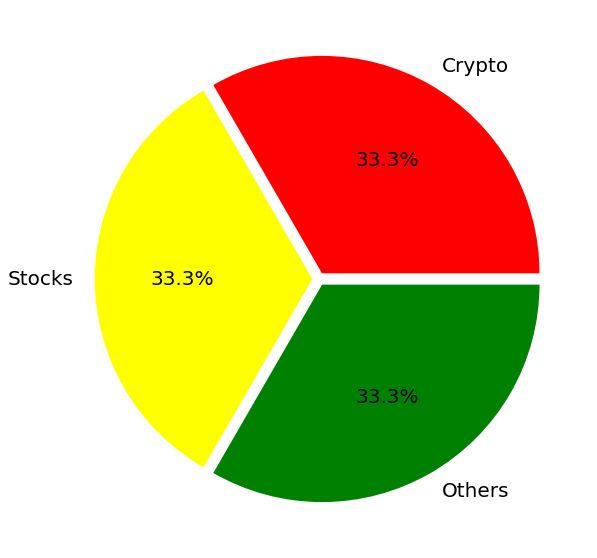

In [68]:
colors = ['red', 'yellow', 'green']
category_names = ['Crypto', 'Stocks', 'Others']
sizes = [df.Category.value_counts()[0], df.Category.value_counts()[1], df.Category.value_counts()[2]]

plt.figure(figsize=(10,10))
plt.pie(sizes, labels=category_names, autopct='%1.1f%%', explode=[.03, .03, .03], colors=colors, textprops={'fontsize': 20})
plt.show()

In [69]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + 
            ' '.join(emoticons).replace('-', ''))
    return text

In [70]:
df.loc[0, 'Article']

'DeFi continues to disrupt traditional financial systems'

In [71]:
# after cleaning

preprocessor(df.loc[0, 'Article'])

'defi continues to disrupt traditional financial systems'

In [72]:
# applying the preprocessor to our data

df['Article'] = df['Article'].apply(preprocessor)

In [73]:
def tokenizer(text):
    return text.split()

tokenizer('runners like running and thus they run')

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

In [74]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tokenizer_porter('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

In [75]:
stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot')[-10:] if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

In [76]:
stop = stopwords.words('english')

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

In [77]:
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

In [80]:
next(stream_docs(path='data.csv'))

ValueError: invalid literal for int() with base 10: 'o'

In [79]:
from sklearn.feature_extraction.text import HashingVectorizer
# from distutils.version import LooseVersion as Version
# from sklearn import __version__ as sklearn_version


vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer
                        )
doc_stream = stream_docs(path='data.csv')

In [81]:
X, y = df.Article, df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [82]:
X_train = vect.fit_transform(X_train)

C:\Users\Ben\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [83]:
X_test = vect.transform(X_test)

In [84]:
# KNN

from sklearn.neighbors import KNeighborsClassifier as KNN
knn_clf = KNN()

knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [85]:
y_pred = knn_clf.predict(X_test)

In [86]:
print('Accuracy: %.3f' % knn_clf.score(X_test, y_test))

Accuracy: 0.889


In [87]:
# Checking the accuracy of our KNN
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"F1_score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.8888888888888888
Recall: 0.8888888888888888
Precision: 0.8888888888888888
F1_score: 0.8888888888888888


<AxesSubplot:>

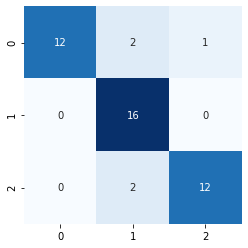

In [88]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [93]:
label = {
    0: 'Crypto',
    1: 'Stocks', 
    2: 'Others'    
}

example = ["Healthcare stocks rebound after sector slump"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[knn_clf.predict(X)[0]], 
       np.max(knn_clf.predict_proba(X))*100))

Prediction: Stocks
Probability: 100.00%


In [94]:
from sklearn.svm import SVC
svm_clf = SVC()

svm_clf.fit(X_train, y_train)

SVC()

In [95]:
y_pred = svm_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"F1_score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.9111111111111111
Recall: 0.9111111111111111
Precision: 0.9111111111111111
F1_score: 0.9111111111111111


In [99]:
label = {
    0: 'Crypto',
    1: 'Stocks', 
    2: 'Others'    
}

example = ["Healthcare stocks rebound after sector slump"]
X = vect.transform(example)
print(f'Prediction: {label[svm_clf.predict(X)[0]]}' )

Prediction: Stocks


In [100]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [101]:
y_pred = tree_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"F1_score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.9555555555555556
Recall: 0.9555555555555556
Precision: 0.9555555555555556
F1_score: 0.9555555555555556


In [102]:
label = {
    0: 'Crypto',
    1: 'Stocks', 
    2: 'Others'    
}

example = ["Healthcare stocks rebound after sector slump"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[tree_clf.predict(X)[0]], 
       np.max(tree_clf.predict_proba(X))*100))

Prediction: Stocks
Probability: 100.00%


In [103]:
# combining our models
from sklearn.ensemble import VotingClassifier

ensemble_classifier = VotingClassifier(
    estimators=[('knn_clf', knn_clf),
                ('tree_clf', tree_clf),
                ('svm', svm_clf)],
    voting='hard')

ensemble_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('knn_clf', KNeighborsClassifier()),
                             ('tree_clf', DecisionTreeClassifier()),
                             ('svm', SVC())])

In [104]:
ensemble_classifier.score(X_train, y_train)

1.0

In [105]:
label = {
    0: 'Crypto',
    1: 'Stocks', 
    2: 'Others'    
}

example = ["Healthcare stocks rebound after sector slump"]
X = vect.transform(example)
print(f'Prediction: {label[ensemble_classifier.predict(X)[0]]}' )

Prediction: Stocks


In [106]:
import joblib
joblib.dump(knn_clf,'knn.joblib')
joblib.dump(svm_clf,'svm.joblib')
joblib.dump(tree_clf,'tree.joblib')
joblib.dump(ensemble_classifier, 'ensemble_classifier.joblib')

['ensemble_classifier.joblib']

In [49]:
def news_scrapeper(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    articles = []
    headline, body = '', ''
    for article in soup.find_all('div'):
        if article.find('h2') != None:
            headline = article.find('h2').get_text(strip=True)
        if article.find('p') != None:
            body = article.find('p').get_text(strip=True)
        articles.append(headline + " " + body)
        
    return articles

In [50]:
url = 'https://allafrica.com/stories/202409300440.html'
articles = news_scrapeper(url)

for i, article in enumerate(articles):
    print(f"Article {i+1}:\n{article}\n")

Article 1:
 

Article 2:
 

Article 3:
 

Article 4:
 

Article 5:
 

Article 6:
 

Article 7:
 

Article 8:
 

Article 9:
 

Article 10:
 

Article 11:
 

Article 12:
 

Article 13:
 

Article 14:
 

Article 15:
 

Article 16:
 

Article 17:
 

Article 18:
Nigeria: MPR Hike Drives Bearish Sentiments in Equity Market Bearish sentiments resurfaced in the Nigerian stock market, as investors reacted to the hike in the Central Bank of Nigeria, CBN's Monetary Policy Rate, MPR, which is the benchmark interest rate for lending by banks and other financial institutions.

Article 19:
Nigeria: MPR Hike Drives Bearish Sentiments in Equity Market Bearish sentiments resurfaced in the Nigerian stock market, as investors reacted to the hike in the Central Bank of Nigeria, CBN's Monetary Policy Rate, MPR, which is the benchmark interest rate for lending by banks and other financial institutions.

Article 20:
Nigeria: MPR Hike Drives Bearish Sentiments in Equity Market Bearish sentiments resurfaced in 

In [55]:
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    tokens = word_tokenize(text.lower())

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    return ' '.join(tokens)

preprocessed_articles = [preprocess_text(article) for article in articles]

for i, article in enumerate(preprocessed_articles):
    print(f"Preprocessed Article {i+1}:\n{article}\n")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed Article 1:


Preprocessed Article 2:


Preprocessed Article 3:


Preprocessed Article 4:


Preprocessed Article 5:


Preprocessed Article 6:


Preprocessed Article 7:


Preprocessed Article 8:


Preprocessed Article 9:


Preprocessed Article 10:


Preprocessed Article 11:


Preprocessed Article 12:


Preprocessed Article 13:


Preprocessed Article 14:


Preprocessed Article 15:


Preprocessed Article 16:


Preprocessed Article 17:


Preprocessed Article 18:
nigeria mpr hike drives bearish sentiments equity market bearish sentiments resurfaced nigerian stock market investors reacted hike central bank nigeria cbn monetary policy rate mpr benchmark interest rate lending banks financial institutions

Preprocessed Article 19:
nigeria mpr hike drives bearish sentiments equity market bearish sentiments resurfaced nigerian stock market investors reacted hike central bank nigeria cbn monetary policy rate mpr benchmark interest rate lending banks financial institutions

Preprocessed

In [108]:
label = {
    0: 'Crypto',
    1: 'Stocks', 
    2: 'Others'    
}

X = vect.transform(preprocessed_articles)
print(f'Prediction: {label[ensemble_classifier.predict(X)[0]]}' )

Prediction: Crypto


In [109]:
X = vect.transform(preprocessed_articles)
print(f'Prediction: {label[knn_clf.predict(X)[0]]}' )

Prediction: Stocks


In [110]:
X = vect.transform(preprocessed_articles)
print(f'Prediction: {label[svm_clf.predict(X)[0]]}' )

Prediction: Crypto


In [111]:
X = vect.transform(preprocessed_articles)
print(f'Prediction: {label[tree_clf.predict(X)[0]]}' )

Prediction: Others


In [113]:
url = 'https://cryptopotato.com/robinhood-expands-services-crypto-transfers-now-available-in-europe/'
articles = news_scrapeper(url)

preprocessed_articles = [preprocess_text(article) for article in articles]

In [114]:
X = vect.transform(preprocessed_articles)
print(f'Prediction: {label[ensemble_classifier.predict(X)[0]]}' )

Prediction: Crypto


In [115]:
X = vect.transform(preprocessed_articles)
print(f'Prediction: {label[knn_clf.predict(X)[0]]}' )

Prediction: Crypto


In [116]:
X = vect.transform(preprocessed_articles)
print(f'Prediction: {label[tree_clf.predict(X)[0]]}' )

Prediction: Others


In [117]:
X = vect.transform(preprocessed_articles)
print(f'Prediction: {label[svm_clf.predict(X)[0]]}' )

Prediction: Crypto
